In [3]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: 28 Oct 2021
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm

# Set panda's options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)

# Better graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-poster')

In [4]:
stays = pd.read_csv('~/projects/MobilityEmbeddings/data/sampled_stays.csv.gz')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
# use_cuda = torch.cuda.is_available()

In [7]:
seq = stays.groupby('user')['GEOID'].get_group('8fd8416afcd7418fdf6e96dca661ec6bea520cd1db209d273ec3cb5cac1e96be')

In [8]:
GEOIDset = stays['GEOID'].unique()
GEOIDmap = {GEOID: i for i, GEOID in enumerate(GEOIDset)}

In [205]:
def prepare_sequence(seq):
    words = [GEOIDmap[GEOID] for GEOID in seq]
    return torch.tensor(words, dtype=torch.long)

def prepare_X(seq):
    X = np.zeros((len(seq), len(GEOIDmap)))
    for i, GEOID in enumerate(seq):
        X[i, GEOID] = 1
    return torch.tensor(X[np.newaxis,:, :], dtype=torch.float)

HIDDEN_SIZE = 64

In [221]:
class SentEnc(nn.Module):
    def __init__(self, num_locations, hidden_size, dropout=0):
        super(SentEnc, self).__init__()
        self.embedding = nn.Embedding(num_locations, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, dropout=dropout, batch_first=True)
        self.linear =  nn.Linear(hidden_size, num_locations)      

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        loc_space = self.linear(lstm_out)
        return loc_space

In [224]:
batch_size = 32
num_layers = 1
hidden_size = 300
lr = 0.005
num_epochs = 3 
criterion = nn.CrossEntropyLoss()
dropout = 0

lstm = SentEnc(len(GEOIDmap), HIDDEN_SIZE, dropout)
optimizer = torch.optim.Adam(lstm.parameters(), lr=lr) 

losses = []
for epoch in range(num_epochs):
  for user, seq in tqdm(stays.groupby('user')['GEOID']):
    seq = prepare_sequence(seq)
    seq = seq.view(1, -1)
    optimizer.zero_grad()
    output = lstm(seq)
    loss = criterion(output.squeeze(0), seq.squeeze(0))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 19.04it/s]


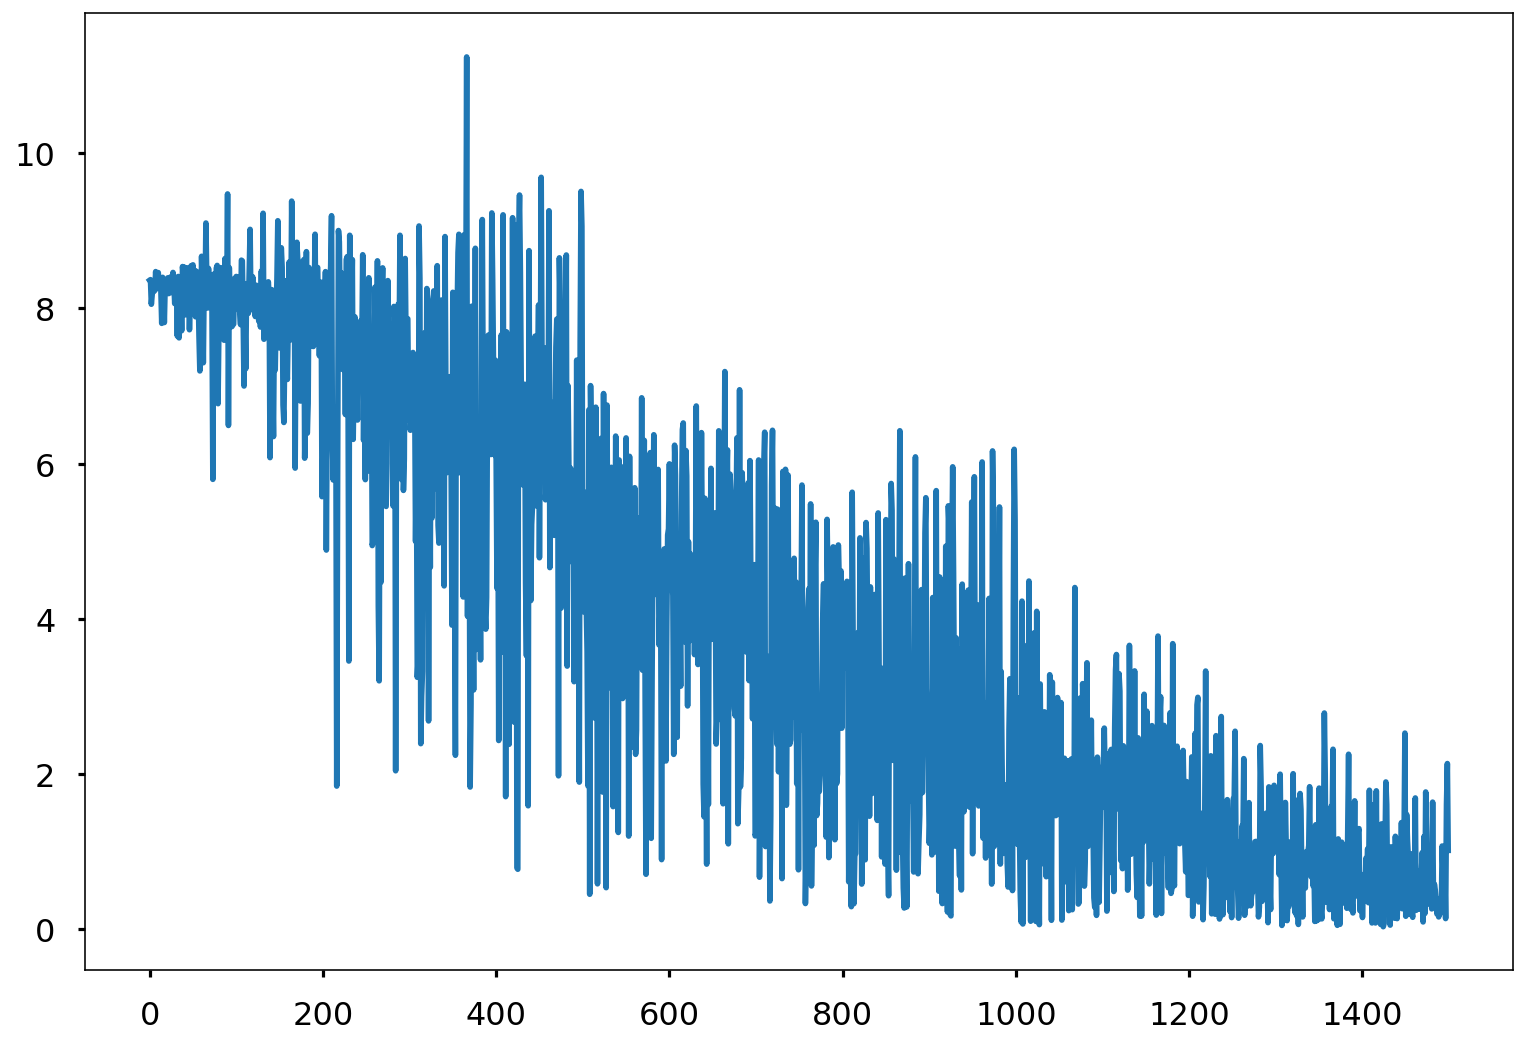

In [225]:
plt.plot(losses)